In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

# Get the Data

In [118]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()

In [119]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,5.380000e+02
mean,941.243303,-0.990423,0.000017,-0.000167,0.000011,-0.000017,-0.000008,1.582748e-11
std,544.944792,0.001021,0.003214,0.000709,0.002140,0.006606,0.001464,2.083377e-11
min,0.000000,-0.991665,-0.004521,-0.001121,-0.003245,-0.009033,-0.002051,-1.546545e-11
25%,470.621651,-0.991455,-0.003192,-0.000872,-0.001964,-0.006552,-0.001494,-9.534182e-13
50%,941.243303,-0.990581,0.000101,-0.000221,0.000025,-0.000425,-0.000049,9.437092e-12
75%,1411.864954,-0.989394,0.003265,0.000532,0.001990,0.006421,0.001465,3.171358e-11
max,1882.486606,-0.988843,0.004521,0.000898,0.003246,0.009931,0.002051,6.628074e-11


Notice that dv_vel varies in the range -2e-7 to 1e-7, while dv_st varies in the range -7e-9 to 4e-9, so the MOST COSTLY maneuvers are much larger using CORRECTION_VEL method than using CORRECTION_ST !!

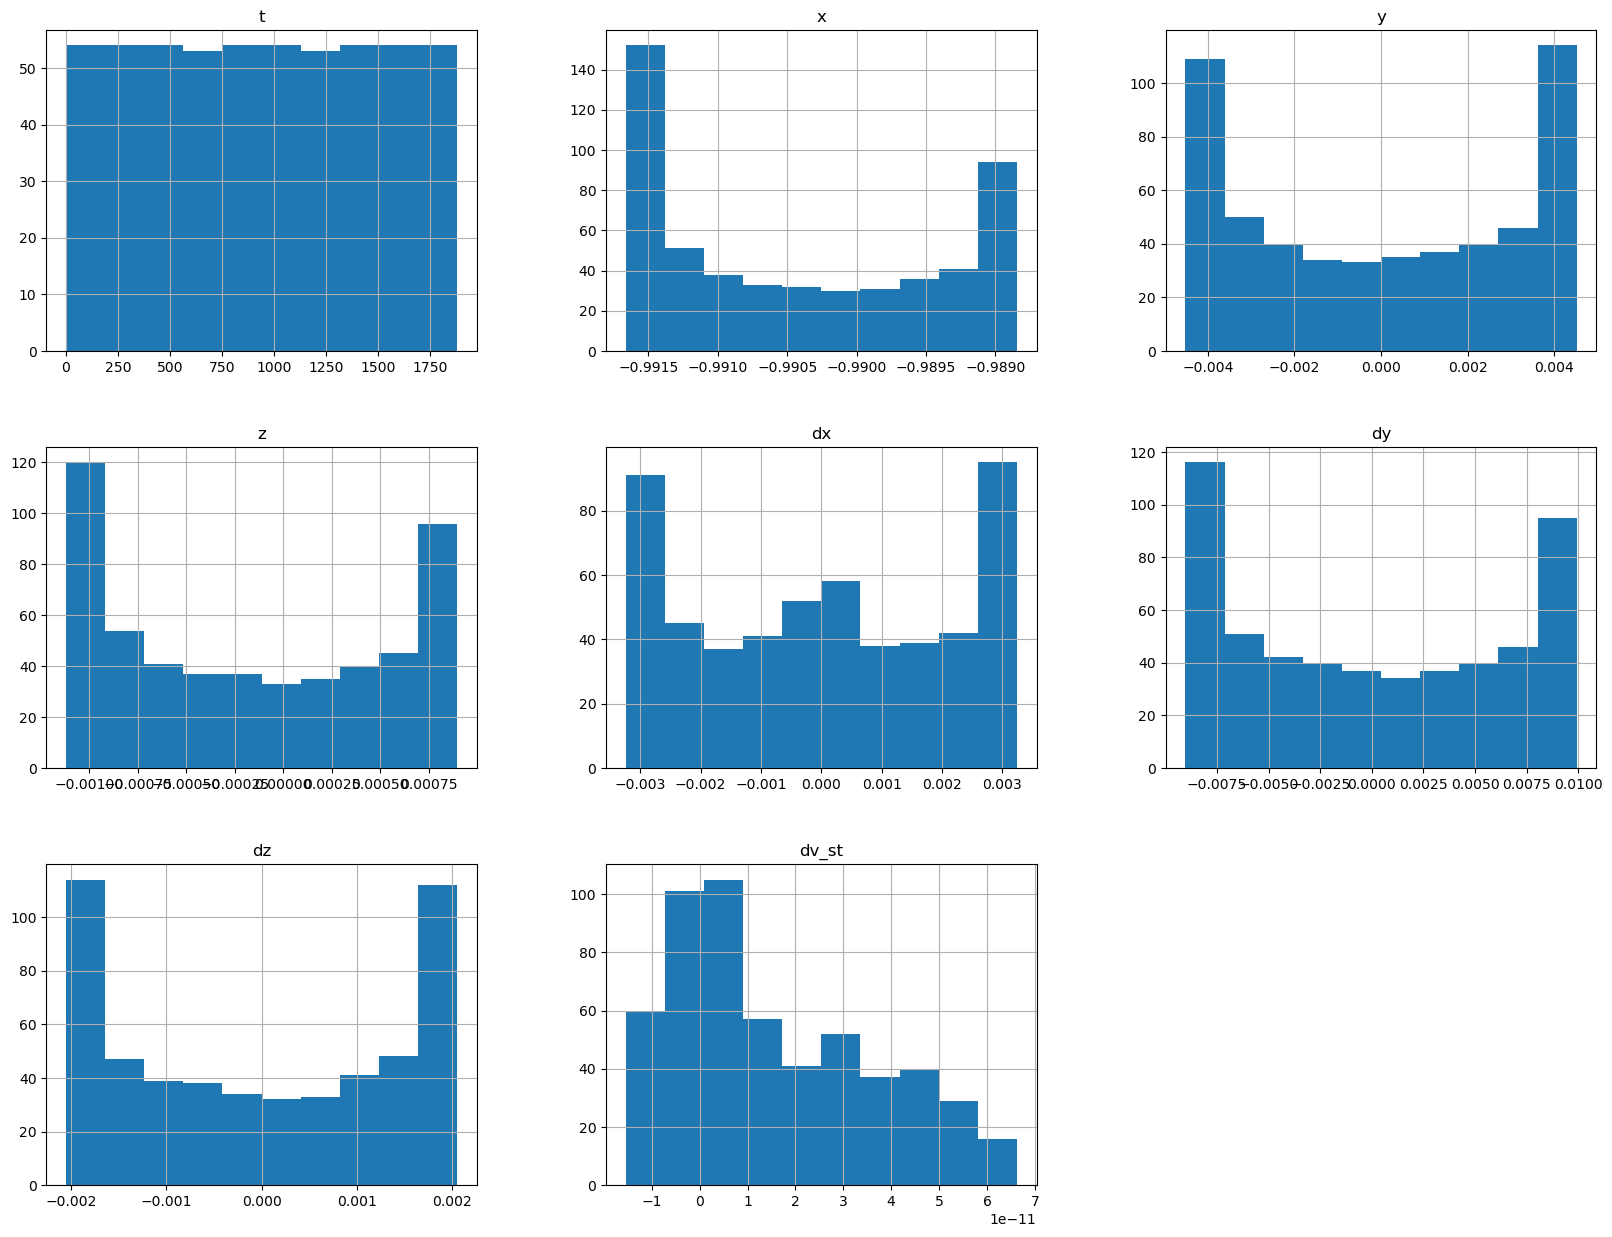

In [120]:
maneuvers.hist(figsize=(20,15))
plt.show()

Histograms of attributes (x,y,z,dx,dy,dz) are tail heavy. We may need to transform to polar coords, or use angle in p.o. as extra attribute.

## Visualizing Data

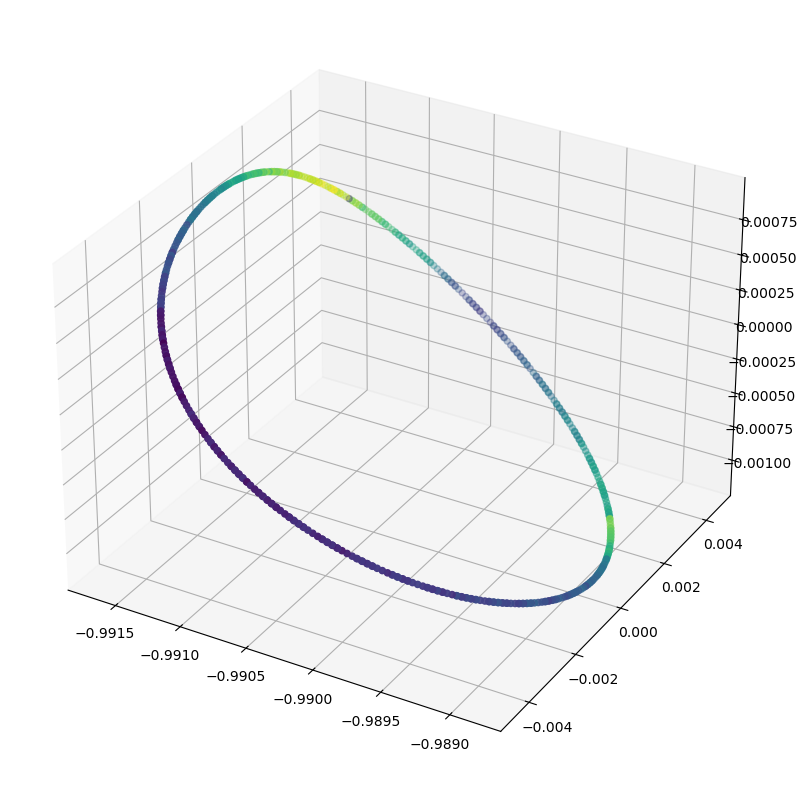

In [121]:
# Visualize shadowing orbit in position space, i.e. the points where correction
# maneuvers are performed.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(maneuvers['x'], maneuvers['y'], maneuvers['z'], c=maneuvers['dv_st'])
plt.show()

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [122]:
#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)
corr_matrix = maneuvers.corr()
corr_matrix["dv_st"].sort_values(ascending=False)

dv_st    1.000000
y        0.706301
dx       0.604214
z        0.218432
dy       0.214492
x       -0.159405
dz      -0.731522
Name: dv_st, dtype: float64

array([[<Axes: xlabel='x', ylabel='x'>, <Axes: xlabel='dx', ylabel='x'>,
        <Axes: xlabel='dv_st', ylabel='x'>],
       [<Axes: xlabel='x', ylabel='dx'>,
        <Axes: xlabel='dx', ylabel='dx'>,
        <Axes: xlabel='dv_st', ylabel='dx'>],
       [<Axes: xlabel='x', ylabel='dv_st'>,
        <Axes: xlabel='dx', ylabel='dv_st'>,
        <Axes: xlabel='dv_st', ylabel='dv_st'>]], dtype=object)

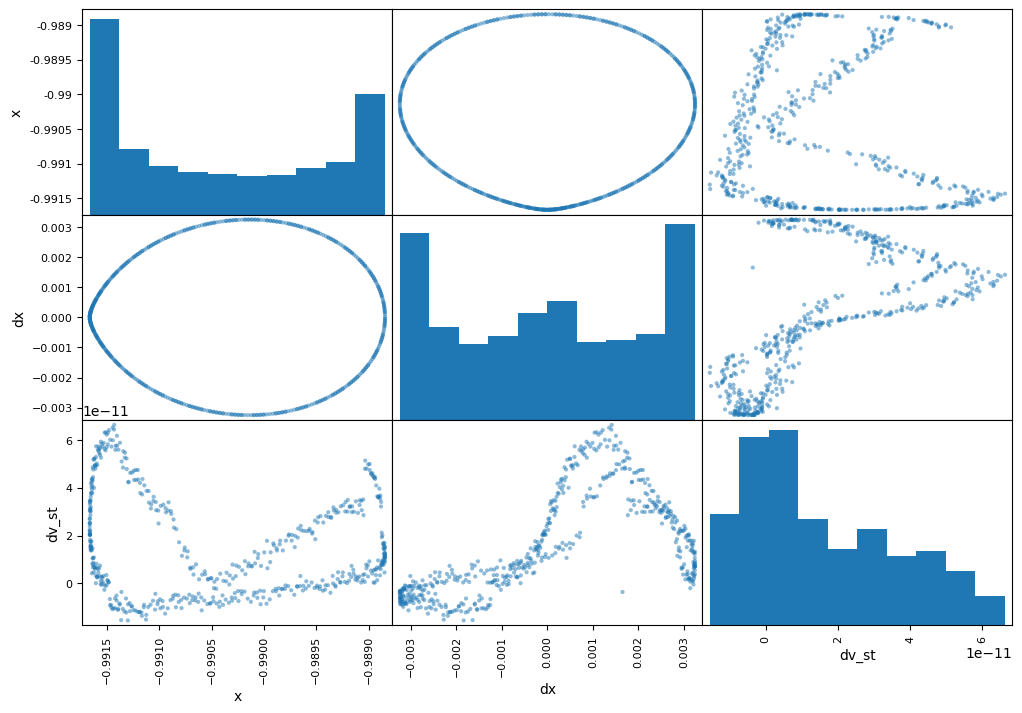

In [123]:
#attributes = ["angle", "x", "dx", "dv_st"]
attributes = ["x", "dx", "dv_st"]
scatter_matrix(maneuvers[attributes], figsize=(12, 8))

dv_st is either positively or negatively correlated to state variables (x,y,z,dx,dy,dz) !!

Notice that angle and dv_st are not correlated, but they are nonlinearly related ("V" shape) !!

# Prepare the Data for Machine Learning Algorithms

## Create a Train/Test Set

In [124]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,dx,dy,dz
0,-0.991363,0.003706,0.000421,0.001651,0.005402,-0.001851
1,-0.990182,0.004321,-0.000465,0.003244,-0.002665,-0.001851
2,-0.988990,0.001680,-0.001057,0.001518,-0.008382,-0.000670
3,-0.989104,-0.002210,-0.001006,-0.001970,-0.007873,0.000886
4,-0.990392,-0.004457,-0.000341,-0.003188,-0.001519,0.001944


In [125]:
## Create Train/Test/Validation Sets

In [126]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
X_train.head()

(322, 6)
(108, 6)
(108, 6)


,x,y,z,dx,dy,dz
395,-0.990819,-0.004490,-0.000058,-0.002813,0.001065,0.002048
482,-0.988881,0.000859,-0.001105,0.000786,-0.008868,-0.000341
160,-0.988847,0.000288,-0.001119,0.000264,-0.009015,-0.000114
101,-0.991483,-0.003194,0.000569,-0.001210,0.006764,0.001648
391,-0.991077,0.004294,0.000145,0.002385,0.002896,-0.002030


In [127]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[2.99769469e-01, 3.38101267e-03, 5.26674486e-01, 6.66150142e-02,
        5.32526067e-01, 9.99312298e-01],
       [9.86633493e-01, 5.94970162e-01, 8.07820634e-03, 6.21025414e-01,
        8.73855663e-03, 4.16968685e-01],
       [9.98523022e-01, 5.31829463e-01, 8.90792834e-04, 5.40711708e-01,
        9.64264804e-04, 4.72234024e-01],
       [6.44111946e-02, 1.46779793e-01, 8.36893114e-01, 3.13528630e-01,
        8.33106633e-01, 9.01714280e-01],
       [2.08227322e-01, 9.74903384e-01, 6.27033479e-01, 8.67469963e-01,
        6.29112993e-01, 5.12563579e-03]])

In [128]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)
y_valid_scaled = scaler_target.transform(y_valid)
y_test_scaled = scaler_target.transform(y_test)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [129]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [130]:
# Let's measure this regression model's RMSE on the whole training set
from sklearn.metrics import mean_squared_error
maneuvers_predictions = lin_reg.predict(X_train_scaled)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.0840860693541896

Clearly not a great score: the SD(dv_st) value is 8.e-7, so a typical prediction error of 6.6.e-7 is not great.

In [131]:
# Let’s train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = tree_reg.predict(X_train_scaled)
tree_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

NOW THIS IS MUCH BETTER!!

In [132]:
#Let's try it out on 5 instances from the test set
some_data = X_test_scaled[10:20]
some_labels = y_test_scaled[10:20]
print("Predictions:", list(tree_reg.predict(some_data)))
print("Labels:", list(some_labels))

Predictions: [0.06381794180776648, 0.5583048643702414, 0.2863362983072686, 0.22398197439018833, 0.2928105315127202, 0.6464253992560522, 0.17891561554236143, 0.7413854882402852, 0.5583048643702414, 0.2928105315127202]
Labels: [array([0.06373624]), array([0.48643469]), array([0.28287334]), array([0.23011423]), array([0.23596637]), array([0.64443189]), array([0.16481516]), array([0.74730999]), array([0.52872321]), array([0.21957011])]


In [133]:
# Let’s train a RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = forest_reg.predict(X_train_scaled)
forest_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.025894256936370586

## Polynomial Regression

In [134]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
maneuvers_pred_poly = poly_features.fit_transform(X_train_scaled)
#print(X_train_scaled.head())
#print(maneuvers_pred_poly[0])

In [135]:
lin_reg = LinearRegression()
lin_reg.fit(maneuvers_pred_poly, y_train_scaled)
maneuvers_predictions = lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.046756460518997706

## SVM Regression

In [136]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2)
svm_poly_reg.fit(X_train_scaled, y_train_scaled)
maneuvers_predictions = svm_poly_reg.predict(X_train_scaled)
svm_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.08947040185363797

## Cross-validation

Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Random Forest model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [137]:
from sklearn.model_selection import cross_val_score
#tree_reg = DecisionTreeRegressor()
forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, X_train_scaled, y_train_scaled,
scoring="neg_root_mean_squared_error", cv=5)
forest_rmse_scores = -scores

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 

In [138]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(forest_rmse_scores)

Scores: [0.09498638 0.04599776 0.0676389  0.07455595 0.03432778]
Mean: 0.06350135695357181
Standard deviation: 0.021392070555537646


## Evaluate Model on Test Set

In [139]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = forest_reg.predict(X_test_scaled)
forest_mse = mean_squared_error(y_test_scaled, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.0370247985340263